# Ising class Correlation

In [2]:
import numpy as np
import scipy
import scipy.signal as signal
import scipy.constants
from scipy.fft import fft2, fftshift
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook
%matplotlib inline
from IPython.display import HTML
import ipywidgets as widgets

from Ising_class import IsingModel
from utils import *

Lorentian : $$L(x) = \frac{A\gamma}{\gamma^2+(x-x_0)^2}$$ $FWHM = 2\gamma$


$$f(x) = e^{-\frac{|x|}{a}}$$

$$TF[f(x)](k) = \frac{2a}{1 + (a k)^2} = \frac{2/a}{1/a^2 + k^2}$$

$$\text{two expressions for $L(x)$} \implies \boxed{a= 1/\gamma} $$

In [3]:
def get_average_PSD(n_samples=1000, N=100, T=3, n_eq=300, plot=True):

    images = np.zeros((n_samples, N, N))

    for i in range(n_samples):
        model = IsingModel(N=N, T=T)
        model.simulate(n_eq, save_data=True)
        images[i] = model.lattice

    PSD = np.zeros((N, N))
    for img in images:
        psd = np.abs( fftshift(fft2(img)) )**2
        PSD += psd

    PSD = PSD / len(images)

    if plot:
        plt.imshow(PSD)
        plt.title('Mean PSD')

    return PSD

In [4]:

def xi_from_PSD(PSD, n_samples, T, N_max_fit=None, A0=None, plot=False):

    # Step 3: Create distance grid
    N = PSD.shape[0]
    x = np.arange(-N//2, N//2)
    y = np.arange(-N//2, N//2)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    # Step 4: Radial averaging
    max_radius = N//2
    radial_profile = np.zeros(max_radius)
    for r in range(max_radius):
        mask = (R >= r) & (R < r + 1)
        radial_profile[r] = PSD[mask].mean()

    def get_symetrise_array(X):
        return np.concatenate([np.flip(X[1:]), [X[0]], X[1:]])

    def get_antisymetrise_array(X):
        return np.concatenate([-np.flip(X[1:]), [X[0]], X[1:]])

    x_data = get_antisymetrise_array(range(max_radius))
    y_data = get_symetrise_array(radial_profile)


    def lorentzian(x, x0, gamma, A):
        return A * (gamma**2) / ((x - x0)**2 + gamma**2)

    # Initial guesses for the parameters
    if A0 is None:
        A0 = np.max(y_data)
    initial_guess = [0, 1, A0]  # Initial guess: [x0, gamma, A]

    # Perform the curve fitting
    if N_max_fit is None:
        N_max_fit = N//2

    i = N//2-N_max_fit
    x_data_fit = x_data[i:-i-1]
    y_data_fit = y_data[i:-i-1]
    params, covariance = curve_fit(lorentzian, x_data_fit, y_data_fit, p0=initial_guess)

    # Extract fitted parameters
    x0_fit, gamma_fit, A_fit = params
    xi = 1/gamma_fit

    print(f"Fitted parameters: x0 = {x0_fit:.4f}, gamma = {gamma_fit:.4f}, A = {A_fit:.4f}")

    # Plotting the results
    if plot:
        y_fit = lorentzian(x_data, x0_fit, gamma_fit, A_fit)

        plt.figure(figsize=(10, 6))
        plt.scatter(x_data, y_data, label='radial average of 2D PSD\n(mean over {} lattices)'.format(n_samples), color='blue', s=10)
        plt.plot(x_data, y_fit, label='Lorentzian Fit', color='red')
        plt.axvline(-N_max_fit, ls='--', color='gray', label='fit range')
        plt.axvline(+N_max_fit, ls='--', color='gray')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(r'Lorentzian Curve Fit, T = {:.3f} ; $\xi = ${:.3f}'.format(T, xi))
        plt.legend()
        plt.grid()
        plt.show()

  
    return xi, x_data, y_data

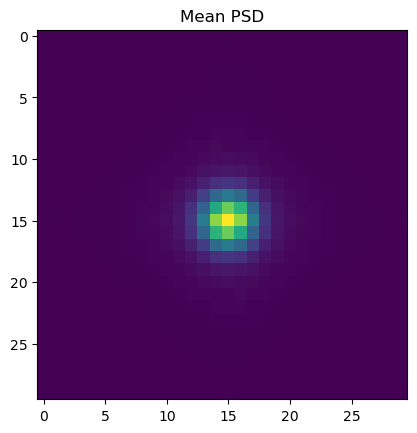

In [5]:
T=1.5
n_samples = 1000
PSD = get_average_PSD(n_samples=n_samples, N=30, T=T, n_eq=50)

In [8]:
T=1.5
n_samples = 1000

xi, x_data, y_data = xi_from_PSD(PSD, T=T, n_samples=n_samples, N_max_fit=20)
xi

ValueError: `ydata` must not be empty!

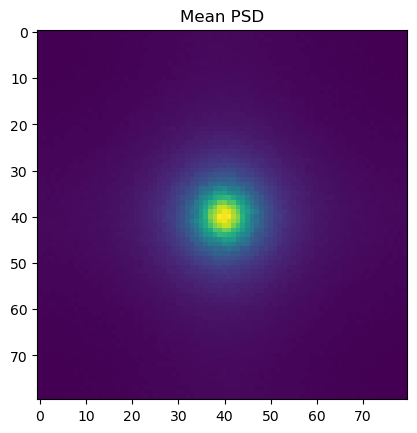

In [34]:
N = 80
T_list = np.arange(2.2, 3, 0.1)
xi_list = np.zeros(len(T_list))

PSD_save = np.zeros((len(T_list), N, N))

for i, T in enumerate(T_list):
    PSD_save[i] = get_average_PSD(n_samples=1000, N=80, T=T, n_eq=200)

In [47]:
xi_list = []
for i, T in enumerate(T_list):
    xi, x_data, y_data = xi_from_PSD(PSD_save[i], T=T, n_samples=1000, N_max_fit=None, plot=False)
    xi_list.append(xi)

Fitted parameters: x0 = -0.0000, gamma = 2.0634, A = 590557.7364
Fitted parameters: x0 = 0.0000, gamma = 2.2395, A = 463191.4399
Fitted parameters: x0 = -0.0000, gamma = 2.4455, A = 352485.1281
Fitted parameters: x0 = -0.0000, gamma = 2.8323, A = 258155.2904
Fitted parameters: x0 = -0.0000, gamma = 3.2075, A = 195816.7442
Fitted parameters: x0 = -0.0000, gamma = 3.9475, A = 140499.8607
Fitted parameters: x0 = -0.0001, gamma = 4.5900, A = 109501.5135
Fitted parameters: x0 = -0.0001, gamma = 5.4275, A = 85816.1917


Text(0, 0.5, '$\\xi$')

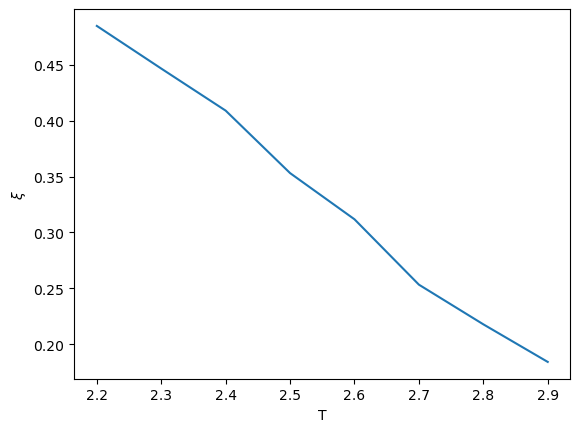

In [50]:
plt.plot(T_list, xi_list)
plt.xlabel('T')
plt.ylabel(r'$\xi$')

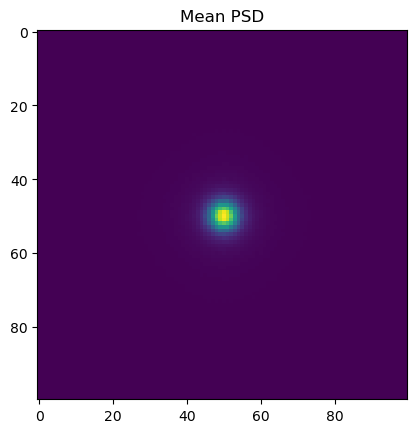

In [51]:
PSD_0 = get_average_PSD(T=2)

Fitted parameters: x0 = -0.0000, gamma = 2.4683, A = 1229348.9438


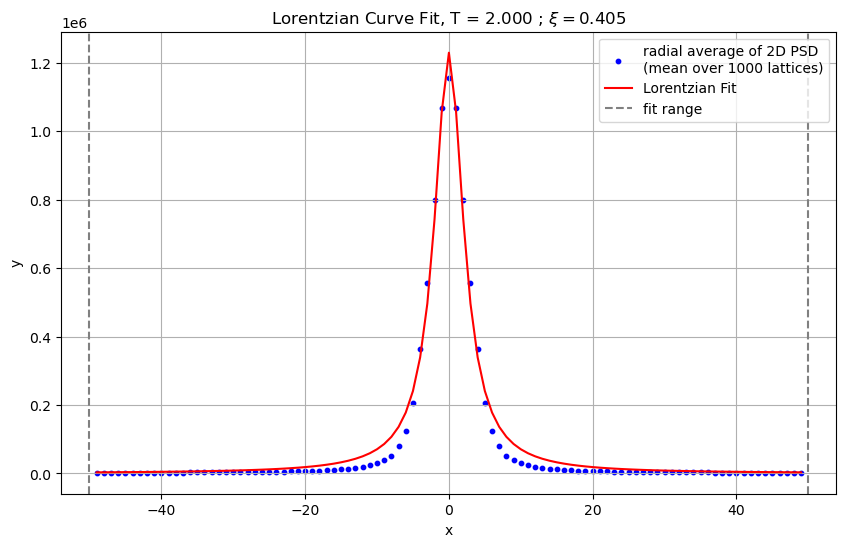

In [59]:
xi, _, _ = xi_from_PSD(PSD_0, n_samples=1000, T=2, plot=True)

## hand written PSD calculation for one direction, formula written by Tommaso

In [285]:
# comme le prof

n = 100
n_qxs = 100
sum_S = np.zeros((n_qxs))

for exp in range(n):
    N = 100
    model = IsingModel(N=N, T=3)
    model.simulate(200)

    img = model.lattice

    qxs = np.linspace(-np.pi/N, np.pi/N, n_qxs)
    S = np.zeros_like(qxs)
    x_index = np.stack([np.arange(N)] * N, axis=0)

    for i, qx in enumerate(qxs):
        S[i] = 1/N**2 * np.mean( np.sum(np.cos(qx*x_index)*img)**2 + np.sum(np.sin(qx*x_index)*img)**2 )

    sum_S += S

avg_S = sum_S/n